In [55]:
import warnings
warnings.filterwarnings('ignore')

In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #data visualization
import seaborn as sns
from operator import add
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/framingham-heart-study-dataset/framingham.csv
/kaggle/input/my-data/my_data.csv


In [57]:
#load the data
data = pd.read_csv('/kaggle/input/framingham-heart-study-dataset/framingham.csv')
data.drop(['education'],axis=1,inplace=True) #dropping the education column because it has no correlation with heart disease
data.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


# Data Analysis

* Missing variables
Handling missing data is important as many machine learning algorithms do not support data with missing values.

In [58]:
#total percentage of missing data
missing_data = data.isnull().sum()
total_percentage = (missing_data.sum()/data.shape[0]) * 100
print(f'The total percentage of missing data is {round(total_percentage,2)}%')

The total percentage of missing data is 12.74%


Since the missing entries account for only 12% of the total data we can drop these entries without losing alot of data.

In [59]:
# drop missing entries
data.dropna(axis=0, inplace=True)

In [60]:
data.shape

(3751, 15)

## Data Distribution

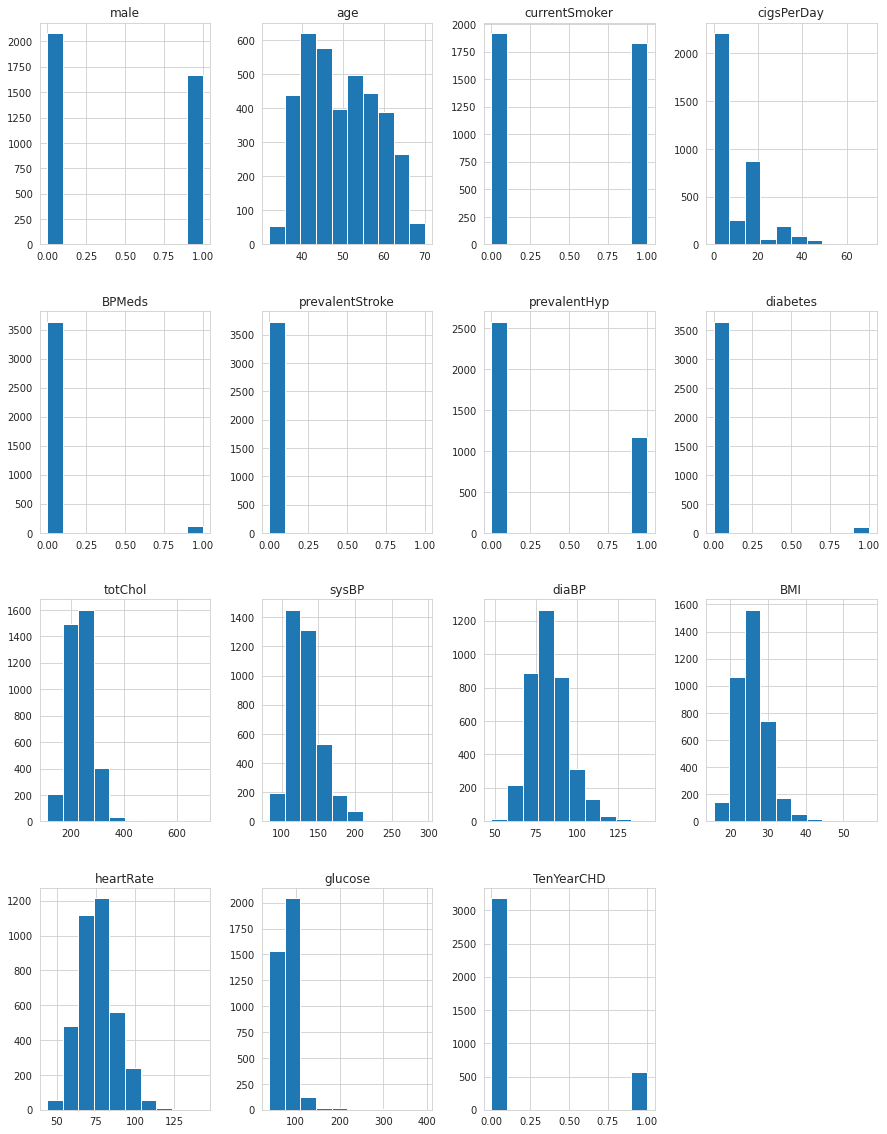

In [61]:
# plot histogram to see the distribution of the data
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.hist(ax = ax)
plt.show()

___The data on the prevalent stroke, diabetes, and blood pressure meds are poorly balanced___

## Case counts

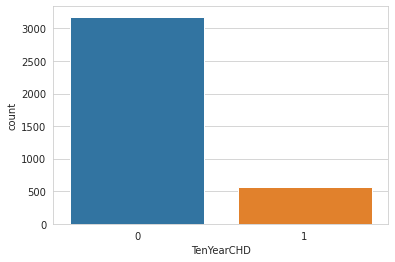

There are 3179 patients without heart disease and 572 patients with the disease


In [62]:
sns.countplot(x='TenYearCHD',data=data)
plt.show()
cases = data.TenYearCHD.value_counts()
print(f"There are {cases[0]} patients without heart disease and {cases[1]} patients with the disease")

_The data is not properly balanced as the number of people without the disease greately exceeds the number of people with the disease._

In [63]:
def stacked_barchart(data, title = None, ylabel = None, xlabel = None):
    default_colors = ['#0affff', '#ffff0a', '#ff0aff']
    # From raw value to percentage
    totals = data.sum(axis=1)
    bars = ((data.T / totals) * 100).T
    r = list(range(data.index.size))

    # Plot
    barWidth = 0.95
    names = data.index.tolist()
    bottom = [0] * bars.shape[0]

    # Create bars
    color_index = 0
    plots = []
    for bar in bars.columns:
        plots.append(plt.bar(r, bars[bar], bottom=bottom, color=default_colors[color_index], edgecolor='black', width=barWidth))
        bottom = list(map(add, bottom, bars[bar]))
        color_index = 0 if color_index >= len(default_colors) else color_index + 1

    # Custom x axis
    plt.title(title)
    plt.xticks(r, names)
    plt.xlabel(data.index.name if xlabel is None else xlabel)
    plt.ylabel(data.columns.name if ylabel is None else ylabel)
    ax = plt.gca()
        
    y_labels = ax.get_yticks()
    ax.set_yticklabels([str(y) + '%' for y in y_labels])

    flat_list = [item for sublist in data.T.values for item in sublist]
    for i, d in zip(ax.patches, flat_list):
        data_label = str(d) + " (" + str(round(i.get_height(), 2)) + "%)"
        ax.text(i.get_x() + 0.45, i.get_y() + 5, data_label, horizontalalignment='center', verticalalignment='center', fontdict = dict(color = 'black', size = 20))

    for item in ([ax.title]):
        item.set_fontsize(27)
        
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)
    
    legend = ax.legend(plots, bars.columns.tolist(), fancybox=True)
    plt.setp(legend.get_texts(), fontsize='20')

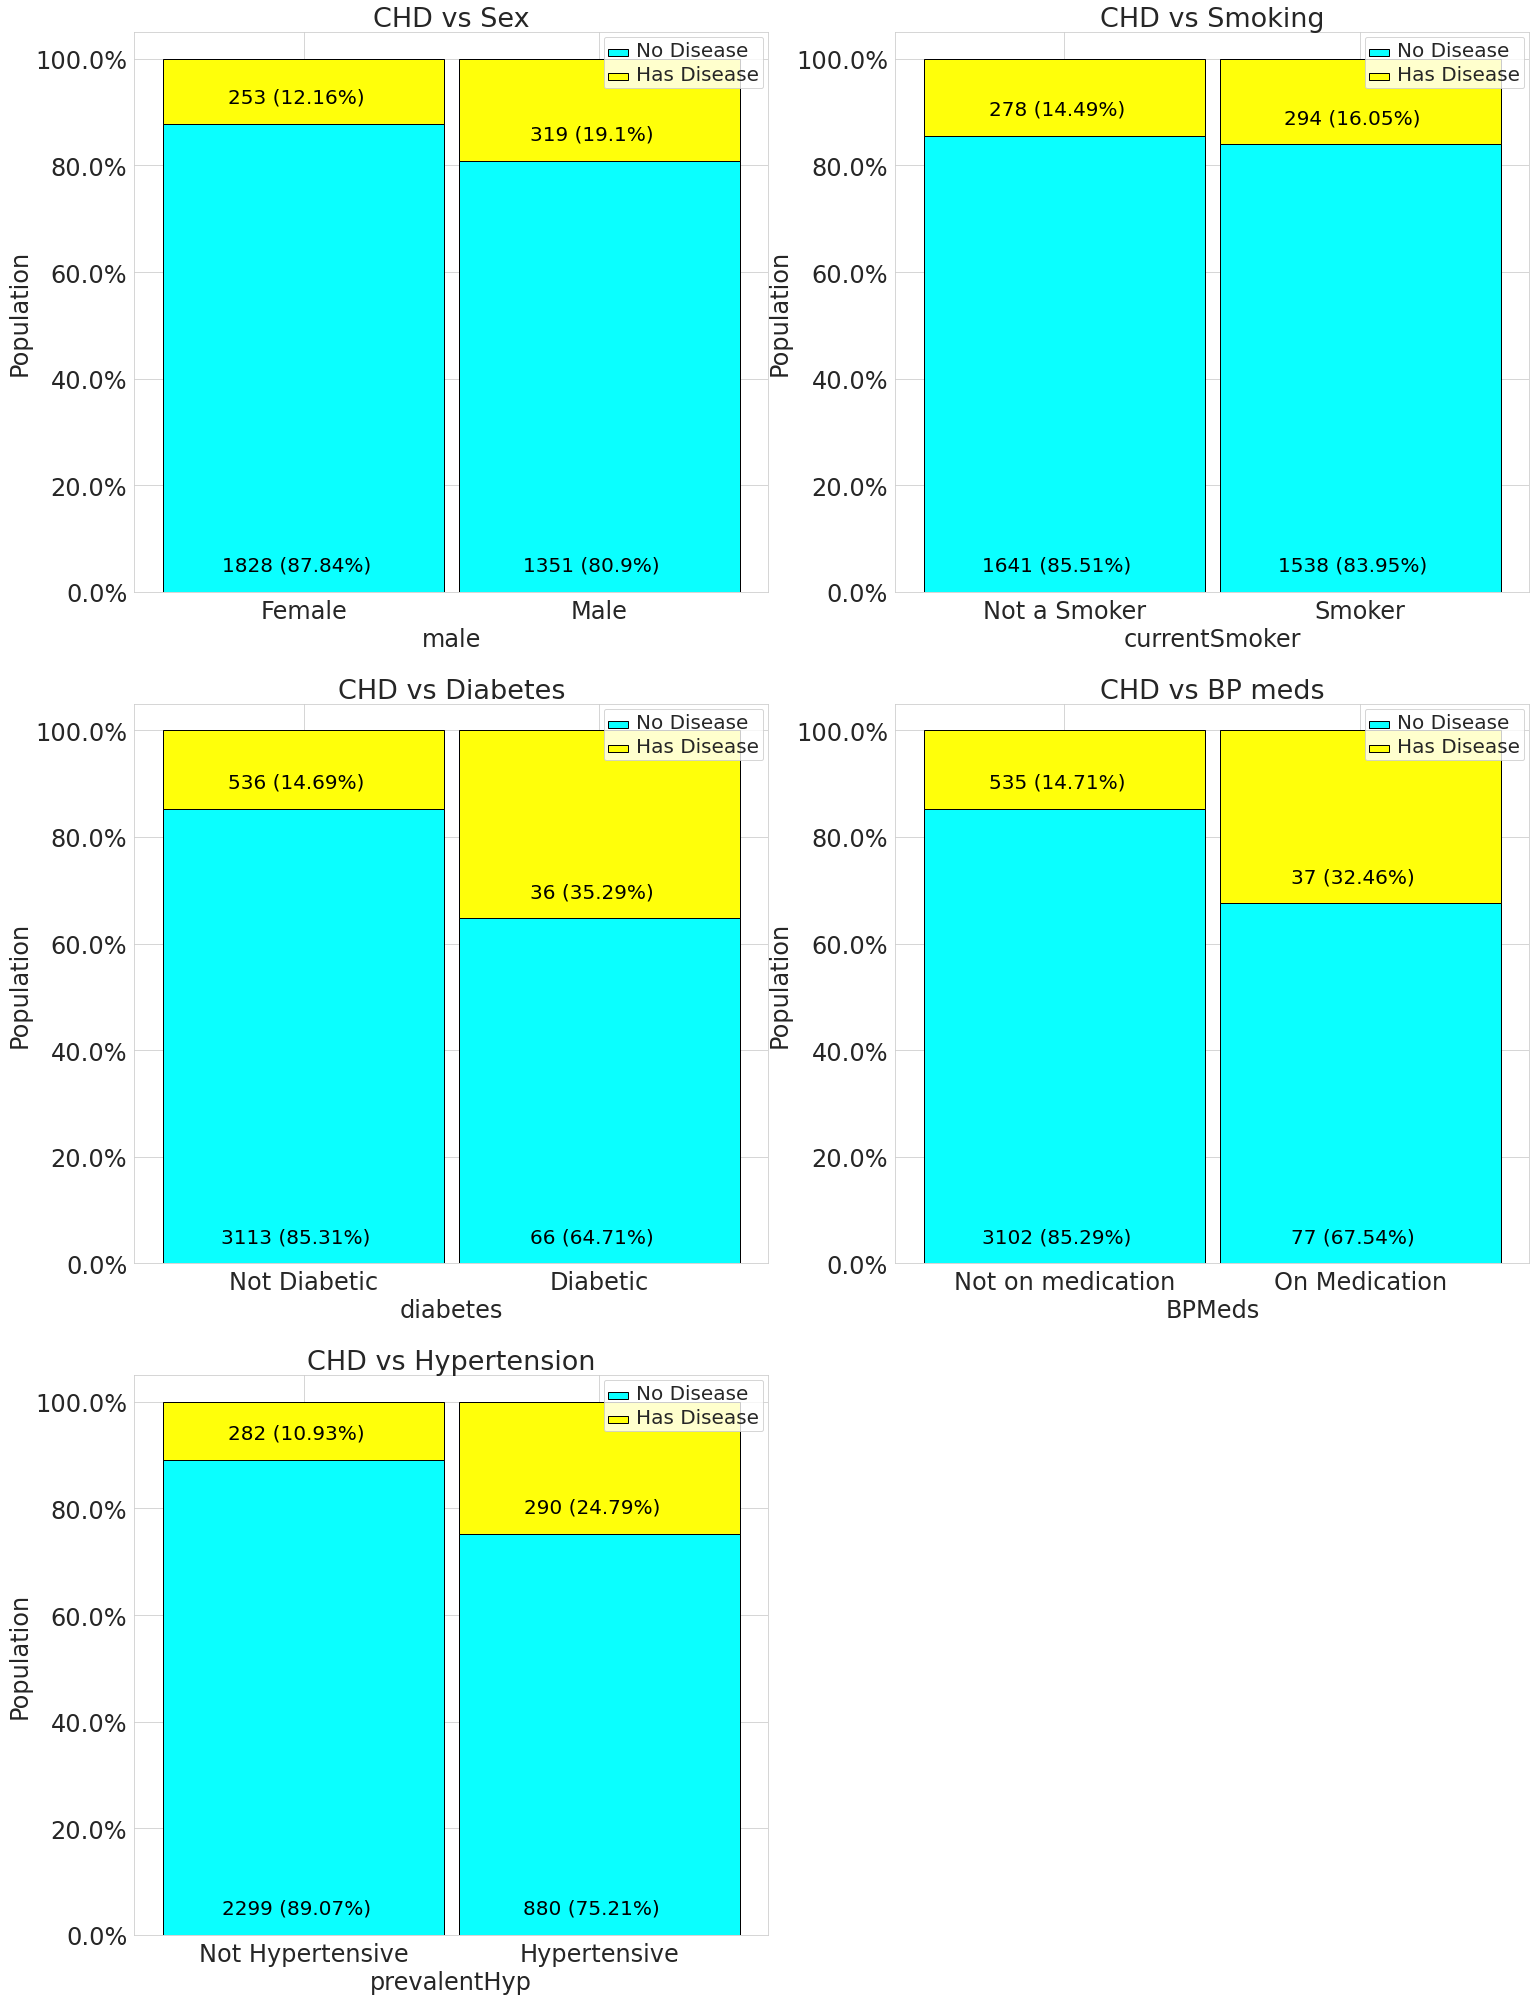

In [64]:
fig = plt.gcf()
fig.set_size_inches(25, 35)
grid_rows = 3
grid_cols = 2

#draw sex vs disease outcome
plt.subplot(grid_rows, grid_cols, 1)
temp = data[['male','TenYearCHD']].groupby(['male','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Female', 1:'Male'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Sex', ylabel = 'Population')

#draw smoking satus vs disease outcome
plt.subplot(grid_rows, grid_cols, 2)
temp = data[['currentSmoker','TenYearCHD']].groupby(['currentSmoker','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not a Smoker', 1:'Smoker'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Smoking', ylabel = 'Population')

#draw diabetes vs disease outcome
plt.subplot(grid_rows, grid_cols, 3)
temp = data[['diabetes','TenYearCHD']].groupby(['diabetes','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not Diabetic', 1:'Diabetic'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Diabetes', ylabel = 'Population')

#draw BP meds vs disease outcome
plt.subplot(grid_rows, grid_cols, 4)
temp = data[['BPMeds','TenYearCHD']].groupby(['BPMeds','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not on medication', 1:'On Medication'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs BP meds', ylabel = 'Population')

#draw Hypertension vs disease outcome
plt.subplot(grid_rows, grid_cols, 5)
temp = data[['prevalentHyp','TenYearCHD']].groupby(['prevalentHyp','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not Hypertensive', 1:'Hypertensive'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Hypertension', ylabel = 'Population')

___conclusions:___
* Slightly more males are suffering from CHD than females
* The percentage of people who have CHD is almost equal between smokers and non smokers
* The percentage of people who have CHD is higher among the diabetic, and those with prevalent hypertesion as compared to those who dont have similar morbidities
* A larger percentage of the people who have CHD are on blood pressure medication

##  Number of people who have disease vs age

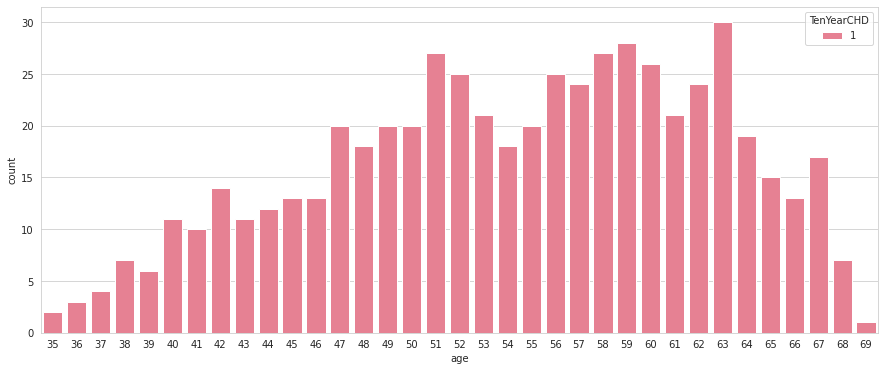

In [65]:
positive_cases = data[data['TenYearCHD'] == 1]
plt.figure(figsize=(15,6))
sns.countplot(x='age',data = positive_cases, hue = 'TenYearCHD', palette='husl')
plt.show()

The number of sick people generally increases with age (highest risk being in between the ages of 51 and 63)

## Correlation Heat map

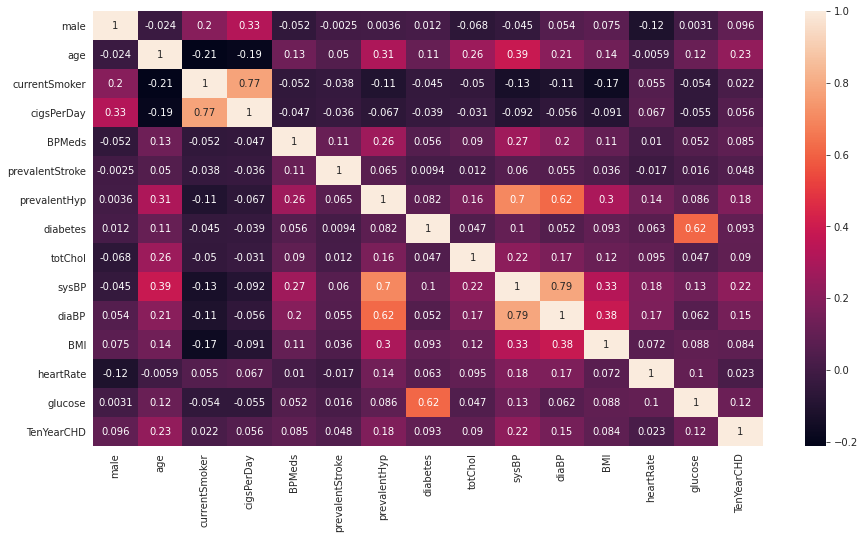

In [66]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot = True)
plt.show()

There are no features with more than 0.5 correlation with the Ten year risk of developing CHD and this shows that the features a poor predictors. However the features with the highest correlations are age, prevalent hypertension and systolic blood pressure

#  Feature Selection
Since having irrelevant features in a data set can decrease the accuracy of the models applied, I used the Boruta Feature Selection technique (wrapper built around the random forest classification algorithm) to select the most important features which were later used to build different models.

___Methodology:___
* Firstly, it adds randomness to the given data set by creating shuffled copies of all features (which are called shadow features).

* Then, it trains a random forest classifier on the extended data set and applies a feature importance measure (the default is Mean Decrease Accuracy) to evaluate the importance of each feature where higher means more important.

* At every iteration, it checks whether a real feature has a higher importance than the best of its shadow features (i.e. whether the feature has a higher Z-score than the maximum Z-score of its shadow features) and constantly removes features which are deemed highly unimportant.

* Finally, the algorithm stops either when all features get confirmed or rejected or it reaches a specified limit of random forest runs.

In [67]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [68]:
#define the features
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight='balanced')

# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2)
 
# find all relevant features
feat_selector.fit(X, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	9
Iteration:

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                          n_estimators=24, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F6FB40DFD10),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F6FB40DFD10, verbose=2)

In [69]:
# show the most important features
most_important = data.columns[:-1][feat_selector.support_].tolist()
most_important

['age', 'sysBP']

We see that age and systolic blood pressures are selected as the most important features for predicting the Ten year risk of developing CHD. However we will use the six most important features to build our models to get more features for more precise prediction.

In [70]:
# select the top 6 features
top_features = data.columns[:-1][feat_selector.ranking_ <=6].tolist()
top_features

['age', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

The top features are:
1. Age
2. Total cholesterol
3. Systolic blood pressure
4. Diastolic blood pressure
5. BMI
6. Heart rate
7. Blood glucose

## Statistics on the top features

In [71]:
import statsmodels.api as sm

In [72]:
X_top = data[top_features]
y = data['TenYearCHD']

In [73]:
res = sm.Logit(y,X_top).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.416958
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3751
Model:                          Logit   Df Residuals:                     3744
Method:                           MLE   Df Model:                            6
Date:                Mon, 17 May 2021   Pseudo R-squ.:                 0.02354
Time:                        14:30:13   Log-Likelihood:                -1564.0
converged:                       True   LL-Null:                       -1601.7
Covariance Type:            nonrobust   LLR p-value:                 3.174e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0223      0.006      3.982      0.000       0.011       0.033
totChol       -0.0029      0.001     -2.716      0.007      -0.005      -0.001
sysBP          0.0245      0.003      7.436      0.000       0.018       0.031
diaBP         -0.0270      0.006     -4.603      0.000      -0.038      -0.015
BMI           -0.0499      0.012     -4.185      0.000      -0.073      -0.027
heartRate     -0.0298      0.004     -8.064      0.000      -0.037      -0.023
glucose        0.0043      0.002      2.616      0.009       0.001       0.007
==============================================================================
"""

In [74]:
params = res.params
conf = res.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

                 5%       95%  Odds Ratio
age        1.011381  1.033813    1.022536
totChol    0.994963  0.999184    0.997071
sysBP      1.018236  1.031493    1.024843
diaBP      0.962258  0.984627    0.973378
BMI        0.929304  0.973798    0.951291
heartRate  0.963690  0.977730    0.970685
glucose    1.001074  1.007518    1.004291


# Balance the dataset using the Synthetic Minority Oversampling Technique (SMOTE).
> SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b. — Page 47, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.

This procedure can be used to create as many synthetic examples for the minority class as are required. It suggests first using random undersampling to trim the number of examples in the majority class, then use SMOTE to oversample the minority class to balance the class distribution.

In [75]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [76]:
X = data[top_features]
y = data.iloc[:,-1]

In [77]:
# the numbers before SMOTE
num_before = dict(Counter(y))

#perform SMOTE

# define pipeline
over = SMOTE(sampling_strategy=0.8)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_smote, y_smote = pipeline.fit_resample(X, y)


#the numbers after SMOTE
num_after =dict(Counter(y_smote))

In [78]:
print(num_before, num_after)

{0: 3179, 1: 572} {0: 3178, 1: 2543}


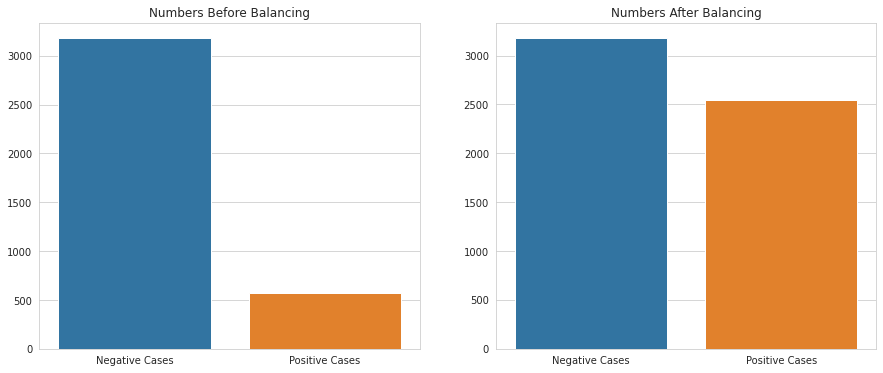

In [79]:
labels = ["Negative Cases","Positive Cases"]
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(labels, list(num_before.values()))
plt.title("Numbers Before Balancing")
plt.subplot(1,2,2)
sns.barplot(labels, list(num_after.values()))
plt.title("Numbers After Balancing")
plt.show()

___The new dataset is much more balanced.___

# Splitting data to Training and Testing set

In [80]:
# new dataset
new_data = pd.concat([pd.DataFrame(X_smote), pd.DataFrame(y_smote)], axis=1)
new_data.columns = ['age', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose','TenYearCHD']
new_data.head()

,age,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,62,300.0,205.5,104.5,32.19,94.0,117.0,0
1,38,150.0,123.0,76.0,20.39,60.0,82.0,0
2,45,280.0,128.0,82.0,29.17,60.0,62.0,0
3,51,326.0,101.0,67.0,22.73,69.0,87.0,0
4,42,224.0,127.5,89.0,29.84,79.0,75.0,0


In [81]:
X_new = new_data[top_features]
y_new= new_data.iloc[:,-1]
X_new.head()

,age,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,62,300.0,205.5,104.5,32.19,94.0,117.0
1,38,150.0,123.0,76.0,20.39,60.0,82.0
2,45,280.0,128.0,82.0,29.17,60.0,62.0
3,51,326.0,101.0,67.0,22.73,69.0,87.0
4,42,224.0,127.5,89.0,29.84,79.0,75.0


In [82]:
# split the dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_new,y_new,test_size=.2,random_state=42)

## Feature Scaling

In [83]:
from sklearn.preprocessing import StandardScaler

In [84]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

# Models used

## Logistic Regression

The goal of logistic regression is to find the best fitting (yet biologically reasonable) model to describe the relationship between the dichotomous characteristic of interest (dependent variable = response or outcome variable) and a set of independent (predictor or explanatory) variables. Logistic regression generates the coefficients (and its standard errors and significance levels) of a formula to predict a logit transformation of the probability of presence of the characteristic of interest.
Rather than choosing parameters that minimize the sum of squared errors (like in ordinary regression), estimation in logistic regression chooses parameters that maximize the likelihood of observing the sample values.

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score,precision_score,classification_report,roc_auc_score,roc_curve

In [86]:
# search for optimun parameters using gridsearch
params = {'penalty':['l1','l2'],
         'C':[0.01,0.1,1,10,100],
         'class_weight':['balanced',None]}
logistic_clf = GridSearchCV(LogisticRegression(),param_grid=params,cv=10)

In [87]:
#train the classifier
logistic_clf.fit(X_train,y_train)

logistic_clf.best_params_

{'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'}

In [88]:
#make predictions
logistic_predict = logistic_clf.predict(X_test)

In [89]:
log_accuracy = accuracy_score(y_test,logistic_predict)
print(f"Using logistic regression we get an accuracy of {round(log_accuracy*100,2)}%")

Using logistic regression we get an accuracy of 65.33%


<AxesSubplot:>

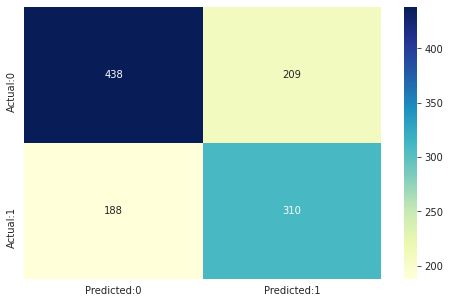

In [90]:
cm=confusion_matrix(y_test,logistic_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [91]:
print(classification_report(y_test,logistic_predict))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       647
           1       0.60      0.62      0.61       498

    accuracy                           0.65      1145
   macro avg       0.65      0.65      0.65      1145
weighted avg       0.66      0.65      0.65      1145



In [92]:
logistic_f1 = f1_score(y_test, logistic_predict)
print(f'The f1 score for logistic regression is {round(logistic_f1*100,2)}%')

The f1 score for logistic regression is 60.96%


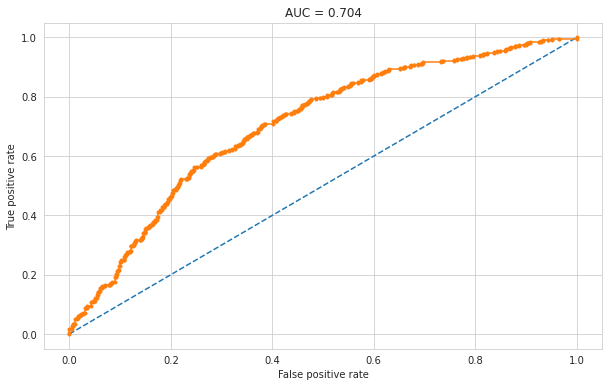

In [93]:
# ROC curve and AUC 
probs = logistic_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

In [94]:
my_data = pd.read_csv('../input/my-data/my_data.csv')
my_data

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
1,20,4,0,0,0,0,0,0,20,120,98,60,22,56,92,0


In [95]:
my_data=my_data[top_features]
my_data

,age,totChol,sysBP,diaBP,BMI,heartRate,glucose
1,4,120,98,60,22,56,92


In [96]:
prediction = logistic_clf.predict(my_data)

In [97]:
print("YOU REALLY ARE HEALTY !") if prediction[0] == 0 else print("YOU'RE AT RISK ! GET LIFE INSURANCE READY")

YOU'RE AT RISK ! GET LIFE INSURANCE READY
